In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
#import quandl

import cvxportfolio as cp

获取股票价格数据及无风险利率

In [2]:
from zipline.research import returns
from zipline.data.treasuries_cn import get_treasury_data

In [3]:
# 注意无风险利率选择一年期，然后除每年交易天数244

tickers = ['300001', '000333', '600771', '600645']
start ='2016-01-01'
end ='2018-05-25'
rets = returns(tickers, start, end)

[2018-05-28 00:48:01.749354] INFO: zipline.finance.metrics.tracker: 模拟1个交易日
首个开盘时间: 2018-05-25 01:31:00+00:00
最后收盘时间: 2018-05-25 07:00:00+00:00


In [4]:
rets.columns = [c.symbol for c in rets.columns] # 转为str

In [5]:
rets['RMB'] = get_treasury_data(start, end)['1year'] / 244.0

In [6]:
rets.head()

,300001,000333,600771,600645,RMB
2016-01-04 00:00:00+00:00,-0.099644,-0.094482,0.0,-0.099985,0.000096
2016-01-05 00:00:00+00:00,-0.055950,0.054211,0.0,-0.032473,0.000097
2016-01-06 00:00:00+00:00,0.020717,0.008265,0.0,0.047871,0.000097
2016-01-07 00:00:00+00:00,-0.100167,-0.080731,0.0,-0.099966,0.000097
2016-01-08 00:00:00+00:00,-0.021627,0.026527,0.0,0.065368,0.000097


We compute rolling estimates of the first and second moments of the returns using a window of 250 days. We shift them by one unit (so at every day we present the optimizer with only past data).

计算滚动244天

In [7]:
r_hat = rets.rolling(window=250, min_periods=250).mean().shift(1).dropna()
Sigma_hat = rets.rolling(window=250, min_periods=250, closed='neither').cov().dropna()

r_hat.tail()

,300001,000333,600771,600645,RMB
2018-05-21 00:00:00+00:00,-0.000697,0.002030,0.001632,0.000440,0.000141
2018-05-22 00:00:00+00:00,-0.000697,0.001958,0.001741,0.000566,0.000141
2018-05-23 00:00:00+00:00,-0.000615,0.001868,0.001876,0.000901,0.000141
2018-05-24 00:00:00+00:00,-0.000637,0.001854,0.001756,0.000896,0.000141
2018-05-25 00:00:00+00:00,-0.000812,0.001784,0.001624,0.000643,0.000141


In [8]:
Sigma_hat.tail()

300001        000333        600771  \
2018-05-25 00:00:00+00:00 300001  3.887251e-04  3.999357e-05  6.173227e-05   
                          000333  3.999357e-05  4.600851e-04  5.122342e-05   
                          600771  6.173227e-05  5.122342e-05  3.071126e-04   
                          600645  1.337086e-04 -1.752075e-05  3.342974e-05   
                          RMB    -5.025579e-09  9.678098e-09 -1.141050e-08   

                                        600645           RMB  
2018-05-25 00:00:00+00:00 300001  1.337086e-04 -5.025579e-09  
                          000333 -1.752075e-05  9.678098e-09  
                          600771  3.342974e-05 -1.141050e-08  
                          600645  7.077758e-04 -5.886650e-09  
                          RMB    -5.886650e-09  6.674884e-11

Here we define the transaction cost and holding cost model (sections 2.3 and 2.4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). The data can be expressed 
as 
- a scalar (like we're doing here), the same value for all assets and all time periods;
- a Pandas Series indexed by the asset names, for asset-specific values; 
- a Pandas DataFrame indexed by timestamps with asset names as columns, for values that vary by asset and in time.

定义交易成本及持有成本
- 标量：所有时间及资产一个固定值
- 序列：特定资产固定值
- 数据框：随时间及资产而变化的值

In [9]:
tcost_model=cp.TcostModel(half_spread=10E-4)
hcost_model=cp.HcostModel(borrow_costs=1E-4)

We define the single period optimization policy (section 4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). 

In [10]:
risk_model = cp.FullSigma(Sigma_hat)
gamma_risk, gamma_trade, gamma_hold = 5., 1., 1.
leverage_limit = cp.LeverageLimit(3)

spo_policy = cp.SinglePeriodOpt(return_forecast=r_hat, 
                                costs=[gamma_risk*risk_model, gamma_trade*tcost_model, gamma_hold*hcost_model],
                                constraints=[leverage_limit])

We run a backtest, which returns a result object. By calling its summary method we get some basic statistics.

运行回测，返回结果对象。调用统计描述方法获取基础统计信息。

In [11]:
rets = rets.loc[r_hat.index] # 与r_hat时间同步

In [12]:
market_sim=cp.MarketSimulator(rets, [tcost_model, hcost_model], cash_key='RMB') 
init_portfolio = pd.Series(index=rets.columns, data=250000.)
init_portfolio.USDOLLAR = 0
results = market_sim.run_multiple_backtest(init_portfolio,
                               start_time=start,  end_time=end,  
                               policies=[spo_policy, cp.Hold()])
results[0].summary()

Number of periods                                     333
Initial timestamp               2017-01-11 00:00:00+00:00
Final timestamp                 2018-05-25 00:00:00+00:00
Portfolio return (%)                               41.052
Excess return (%)                                  37.636
Excess risk (%)                                    28.278
Sharpe ratio                                        1.333
Max. drawdown                                      22.004
Turnover (%)                                      230.797
Average policy time (sec)                           0.022
Average simulator time (sec)                        0.003


In [15]:
results

The total value of the portfolio in time.

投资组合总值时间序列

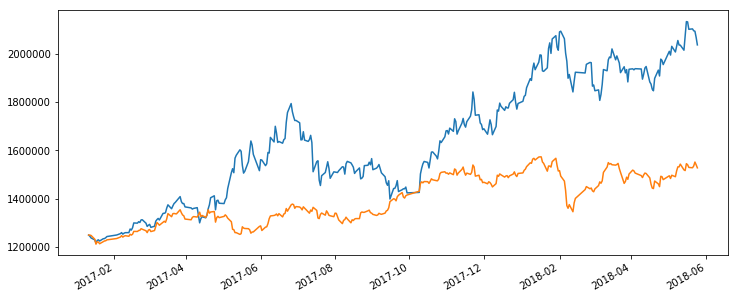

In [13]:
results[0].v.plot(figsize=(12,5))
results[1].v.plot(figsize=(12,5))

The weights vector of the portfolio in time.

投资组合权重矢量时间序列

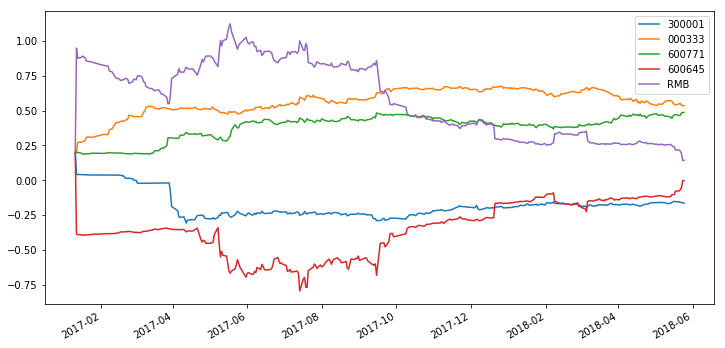

In [14]:
results[0].w.plot(figsize=(12,6))